In [1]:

# Step 1.1 — Create project folders (run once)

import os

folders = [
    "src/io", "src/models", "src/mpc", "src/simulation", "src/plotting",
    "scripts", "data", "logs"
]
for d in folders:
    os.makedirs(d, exist_ok=True)

print("Folders created:", folders)


Folders created: ['src/io', 'src/models', 'src/mpc', 'src/simulation', 'src/plotting', 'scripts', 'data', 'logs']


In [41]:
!python scripts/generate_example_data.py

Example data written to data/day_ahead_15min.csv and data/rt_5min.csv


In [55]:
!python test_io_alignment.py

             timestamp         block_start  ... solar_actual_kw  actual_available
0  2026-01-03 00:00:00 2026-01-03 00:00:00  ...            <NA>             False
1  2026-01-03 00:05:00 2026-01-03 00:00:00  ...            <NA>             False
2  2026-01-03 00:10:00 2026-01-03 00:00:00  ...            <NA>             False
3  2026-01-03 00:15:00 2026-01-03 00:15:00  ...            <NA>             False
4  2026-01-03 00:20:00 2026-01-03 00:15:00  ...            <NA>             False
5  2026-01-03 00:25:00 2026-01-03 00:15:00  ...            <NA>             False
6  2026-01-03 00:30:00 2026-01-03 00:30:00  ...            <NA>             False
7  2026-01-03 00:35:00 2026-01-03 00:30:00  ...            <NA>             False
8  2026-01-03 00:40:00 2026-01-03 00:30:00  ...            <NA>             False
9  2026-01-03 00:45:00 2026-01-03 00:45:00  ...            <NA>             False
10 2026-01-03 00:50:00 2026-01-03 00:45:00  ...            <NA>             False
11 2026-01-03 00

In [ ]:

# src/simulation/simulator.py
# End-to-end day simulation with block-energy MPC

from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Dict

from src.models.battery import BatteryParams, BatteryState
from src.mpc.mpc_controller import BlockEnergyMPC
from src.io.data_loader import build_tracking_frame

def run_day_with_block_energy_mpc(
    config: Dict,
    df_tracking: pd.DataFrame,
) -> pd.DataFrame:
    """
    Run the block-energy MPC over the whole day's 5-min timeline.
    df_tracking must be built by data_loader.build_tracking_frame(...) and include:
      timestamp, block_start, block_end, substep_in_block, E_target_kwh,
      solar_forecast_kw, solar_actual_kw (optional), actual_available (bool)
    """
    batt = BatteryParams(**config["battery"])
    state = BatteryState(batt)
    ctrl = BlockEnergyMPC(
        dt_minutes=config["time"]["dt_minutes_rtu"],
        p_discharge_max_kw=batt.p_discharge_max_kw,
        p_charge_max_kw=batt.p_charge_max_kw,
        eta_charge=batt.eta_charge,
        eta_discharge=batt.eta_discharge,
        ramp_rate_kw_per_step=config["time"].get("ramp_rate_kw_per_step"),
    )

    dt_minutes = config["time"]["dt_minutes_rtu"]

    results = []
    # Iterate through each 5-min timestamp
    for i in range(len(df_tracking)):
        row = df_tracking.iloc[i]
        cur_ts = row["timestamp"]
        cur_block_start = row["block_start"]
        cur_substep = int(row["substep_in_block"])

        # Extract the 3 rows of the current block (order by substep)
        block_rows = df_tracking[df_tracking["block_start"] == cur_block_start].sort_values("substep_in_block")
        # Prepare arrays for the controller
        br = {
            "timestamps": block_rows["timestamp"].to_numpy(),
            "substeps": block_rows["substep_in_block"].to_numpy(),
            "E_target_kwh": block_rows["E_target_kwh"].to_numpy(),
            "solar_forecast_kw": block_rows["solar_forecast_kw"].to_numpy(),
            "solar_actual_kw": block_rows["solar_actual_kw"].to_numpy(dtype=float) if "solar_actual_kw" in block_rows else np.full(3, np.nan),
            "actual_available": block_rows["actual_available"].to_numpy(dtype=bool),
            "current_index": int(np.where(block_rows["timestamp"] == cur_ts)[0][0]),
        }

        # Compute the current setpoint for the BESS
        p_kw = ctrl.compute_current_setpoint(
            E_kwh=state.energy_kwh,
            soc_min_kwh=batt.soc_min_kwh,
            soc_max_kwh=batt.soc_max_kwh,
            last_p_kw=state.last_p_kw,
            block_rows=br,
        )

        # Forecast-based grid output for current step (for visualization)
        solar_fc_kw = float(row["solar_forecast_kw"])
        grid_out_kw = solar_fc_kw + p_kw

        # Advance battery state by one 5-min step
        state.step(p_kw, dt_minutes)

        # Convenience: 15-min expected power repeated across the block for plotting
        target_power_kw = float(row["E_target_kwh"] / 0.25)  # E_target / 0.25 h = kW

        results.append({
            "timestamp": pd.Timestamp(cur_ts),
            "block_start": pd.Timestamp(cur_block_start),
            "substep_in_block": cur_substep,
            "E_target_kwh": float(row["E_target_kwh"]),
            "target_power_kw": target_power_kw,
            "solar_forecast_kw": solar_fc_kw,
            "solar_actual_kw": float(row["solar_actual_kw"]) if pd.notna(row["solar_actual_kw"]) else np.nan,
            "actual_available": bool(row["actual_available"]),
            "battery_power_kw": float(p_kw),
            "grid_output_kw": float(grid_out_kw),
            "soc_kwh": float(state.energy_kwh),
        })

    return pd.DataFrame(results)


Mean Abs Tracking Error (power-domain): 1,330 kW
Saved results to: logs\mpc_block_energy_results.csv


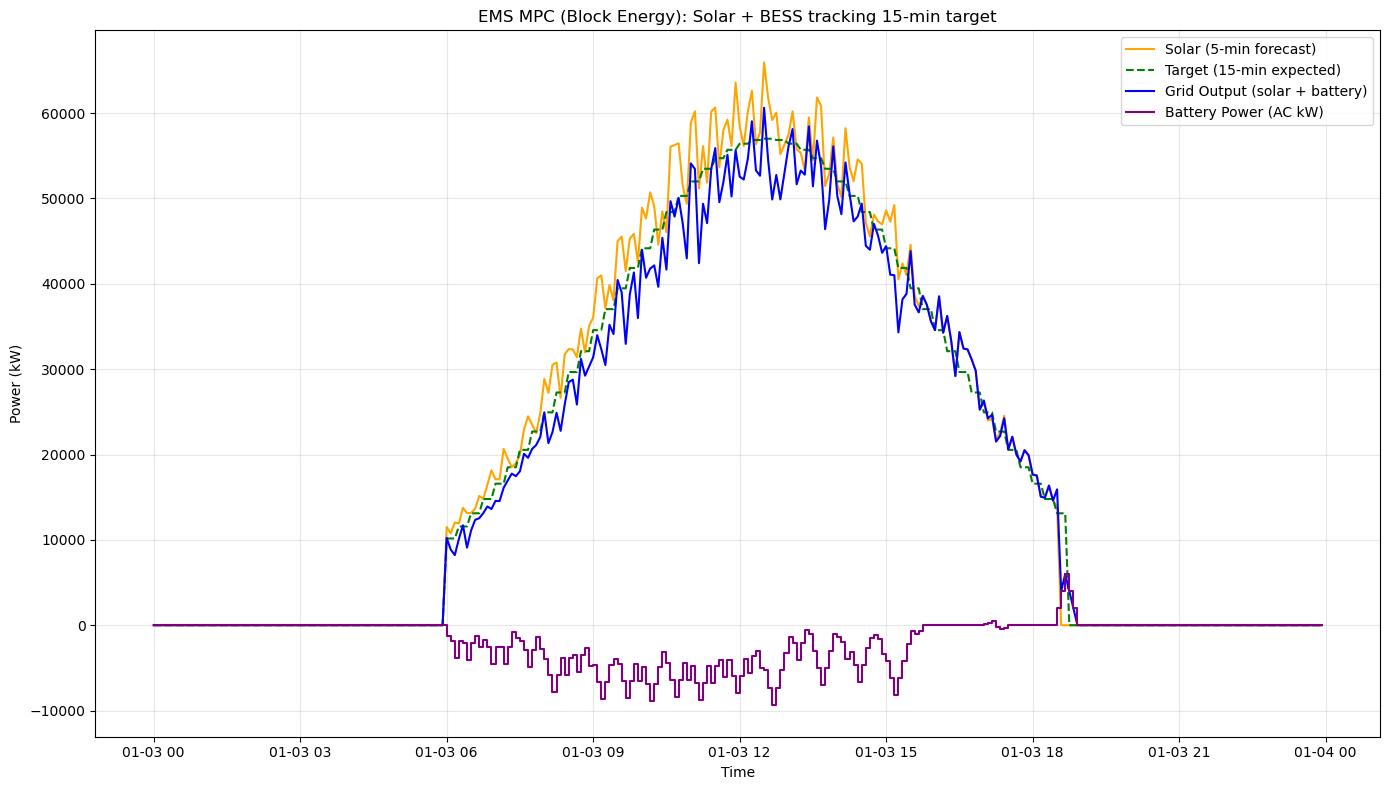

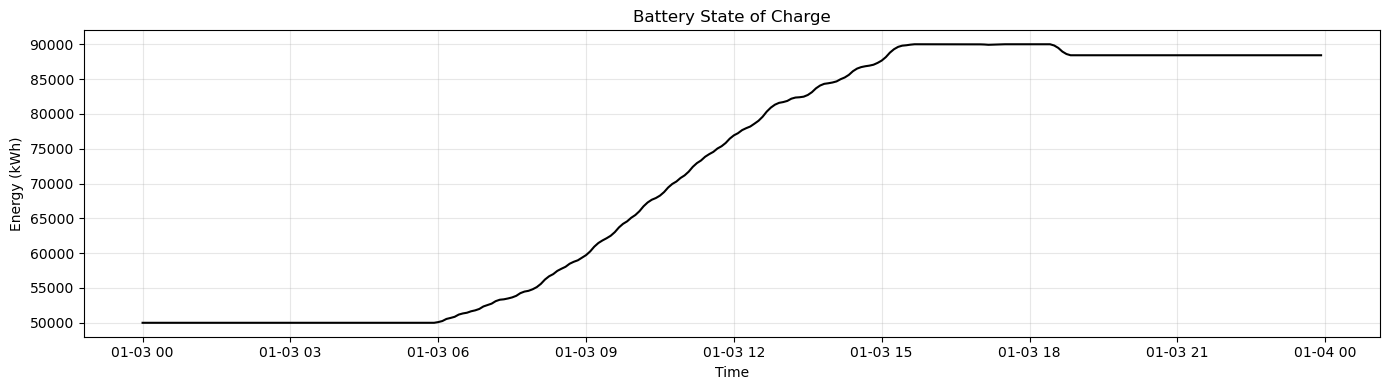

In [1]:

# main.py
# Run the EMS MPC (block energy) for a full day

import os
from importlib import import_module
import pandas as pd

from src.io.data_loader import (
    read_day_ahead_power_15min, read_forecast_5min, read_actual_5min, build_tracking_frame
)
from src.simulation.simulator import run_day_with_block_energy_mpc
from src.plotting.plots import plot_day, plot_soc

def main():
    # Load config
    CONFIG = import_module("config").CONFIG

    # Ensure folders
    os.makedirs(CONFIG["tracking"]["log_dir"], exist_ok=True)

    # Data paths
    da_path  = "data/day_ahead_15min.csv"
    fc5_path = "data/rt_5min.csv"
    act5_path = "data/solar_actual_5min.csv"  # optional

    # Read inputs
    df15 = read_day_ahead_power_15min(da_path)
    df5f = read_forecast_5min(fc5_path)
    try:
        df5a = read_actual_5min(act5_path)
    except FileNotFoundError:
        df5a = None

    # Build tracking frame (maps 5-min rows to 15-min blocks with E_target_kwh)
    tracking = build_tracking_frame(df15, df5f, df5a, dt5_min=CONFIG["time"]["dt_minutes_rtu"])

    # Run MPC simulation
    df = run_day_with_block_energy_mpc(CONFIG, tracking)

    # Save CSV results
    out_csv = os.path.join(CONFIG["tracking"]["log_dir"], "mpc_block_energy_results.csv")
    df.to_csv(out_csv, index=False)

    # Plots
    if CONFIG["tracking"]["save_plots"]:
        plot_day(df, os.path.join(CONFIG["tracking"]["log_dir"], "power_tracking.png"))
        plot_soc(df, os.path.join(CONFIG["tracking"]["log_dir"], "soc.png"))

    # Summary: tracking error (power-domain; quick view)
    mae_kw = (df["grid_output_kw"] - df["target_power_kw"]).abs().mean()
    print(f"Mean Abs Tracking Error (power-domain): {mae_kw:,.0f} kW")
    print(f"Saved results to: {out_csv}")

if __name__ == "__main__":
    main()


In [ ]:
# 🎯 Next enhancements (I can add them if you want)


# Terminal SOC target
# Add a soft penalty or hard constraint so the battery ends the day at a desired SOC (e.g., 50%).


# Energy‑domain diagnostic plot per block
# Plot cumulative energy delivered (solar + battery) vs target energy within each 15‑min block for a few sample blocks (e.g., 06:00–06:15, 09:00–09:15).


# Formal QP MPC (cvxpy)
# Replace the heuristic with a quadratic program to explicitly minimize tracking error and smoothness, subject to constraints (power, ramp, SOC).